# Customer segmentation (clustering)
## Hotel Customer Data
### This notebook was developed by:

- João Venichand - 20211644
- Gonçalo Custódio - 20211643
- Diogo Correia - 20211586
- Duarte Emanuel - 200564

### Data Description
Dataset related to customer behavior and preferences in a hotel context. Contains historical booking patterns, revenue data, and customer-specific preferences.

#### Customer Information:
- **ID**: Unique customer identifier (numeric)
- **Nationality**: Customer nationality (categorical: e.g., 'BRA', 'USA')
- **Age**: Customer age (numeric)
- **DaysSinceCreation**: Days since the customer account was created (numeric)
- **NameHash**: Anonymized hash of the customer’s name (text)
- **DocIDHash**: Anonymized hash of the customer’s ID document (text)
- **LodgingRevenue**: Total lodging revenue (numeric)
- **OtherRevenue**: Total revenue from non-lodging services (e.g., food, spa) (numeric)
- **MarketSegment**: Customer market segment (e.g., 'corporate', 'leisure') (categorical)

#### Booking Behaviour:
- **AverageLeadTime**: Average days between booking and arrival date (numeric)
- **BookingsCanceled**: Total canceled bookings by the customer (numeric)
- **BookingsNoShowed**: Total "no-show" bookings (numeric)
- **BookingsCheckedin**: Total bookings that resulted in stays (numeric)
- **PersonNights**: Total person-nights stayed (adults + children × nights) (numeric)
- **RoomNights**: Total room-nights stayed (rooms × nights) (numeric)
- **DistributionChannel**: Booking distribution channel (e.g., 'direct', 'agency') (categorical)

#### Customer Preferences (Binary: 0 = No, 1 = Yes)
- **SRHighFloor**: Requests rooms on higher floors
- **SRLowFloor**: Requests rooms on lower floors
- **SRMediumFloor**: Requests rooms on middle floors
- **SRAccessibleRoom**: Requests accessible rooms
- **SRBathtub**: Requests rooms with bathtubs
- **SRShower**: Requests rooms with showers
- **SRCrib**: Requests cribs
- **SRKingSizeBed**: Requests king-size beds
- **SRTwinBed**: Requests twin beds
- **SRNearElevator**: Requests rooms near elevators
- **SRAwayFromElevator**: Requests rooms away from elevators
- **SRNoAlcoholInMiniBar**: Requests mini-bars without alcohol
- **SRQuietRoom**: Requests quiet rooms

## Importing Libraries


__`Step 1`__ Import the required libraries.

In [719]:
import pandas as pd 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.ticker as ticker
import umap
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Understanding 


__`Step 2`__ Import the dataset, storing it in the data frame **data**.

In [720]:
data = pd.read_csv('Case1_HotelCustomerSegmentation.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

In [721]:
data.drop(columns=["NameHash", "DocIDHash", "MarketSegment"], inplace=True)

__`Step 3`__ Display the data.

In [722]:
data.head(5)

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,59,292.0,82.3,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,61,280.0,53.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,93,240.0,60.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__`Step 4`__ Turn the ID into the index of the data.

In [723]:
if data['ID'].duplicated().any():
    print("There are duplicate IDs in the dataset.")
else:
    data.set_index('ID', inplace=True)

__`Step 5`__ Summary statistics for all variables

In [724]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0
BookingsNoShowed,111733.0,NaN,NaN,NaN,0.0006,0.028217,0.0,0.0,0.0,0.0,3.0
BookingsCheckedIn,111733.0,NaN,NaN,NaN,0.737607,0.730889,0.0,0.0,1.0,1.0,76.0
PersonsNights,111733.0,NaN,NaN,NaN,4.328318,4.630739,0.0,0.0,4.0,6.0,116.0


__`Step 6`__ Check missing values

In [725]:
print(data.isnull().sum())

Nationality                0
Age                     4172
DaysSinceCreation          0
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64


In [726]:
categorical_cols = ["Nationality", "DistributionChannel"]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [727]:
nationality_cols = [col for col in data.columns if col.startswith("Nationality_")]
nationality_counts = data[nationality_cols].sum().sort_values(ascending=False)
distribution_cols = [col for col in data.columns if col.startswith("DistributionChannel_")]
distribution_counts = data[distribution_cols].sum().sort_values(ascending=False)

In [728]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]

data[binary_cols] = data[binary_cols].apply(pd.to_numeric, errors='coerce')

__`Step 7`__ Histograms of numeric variables

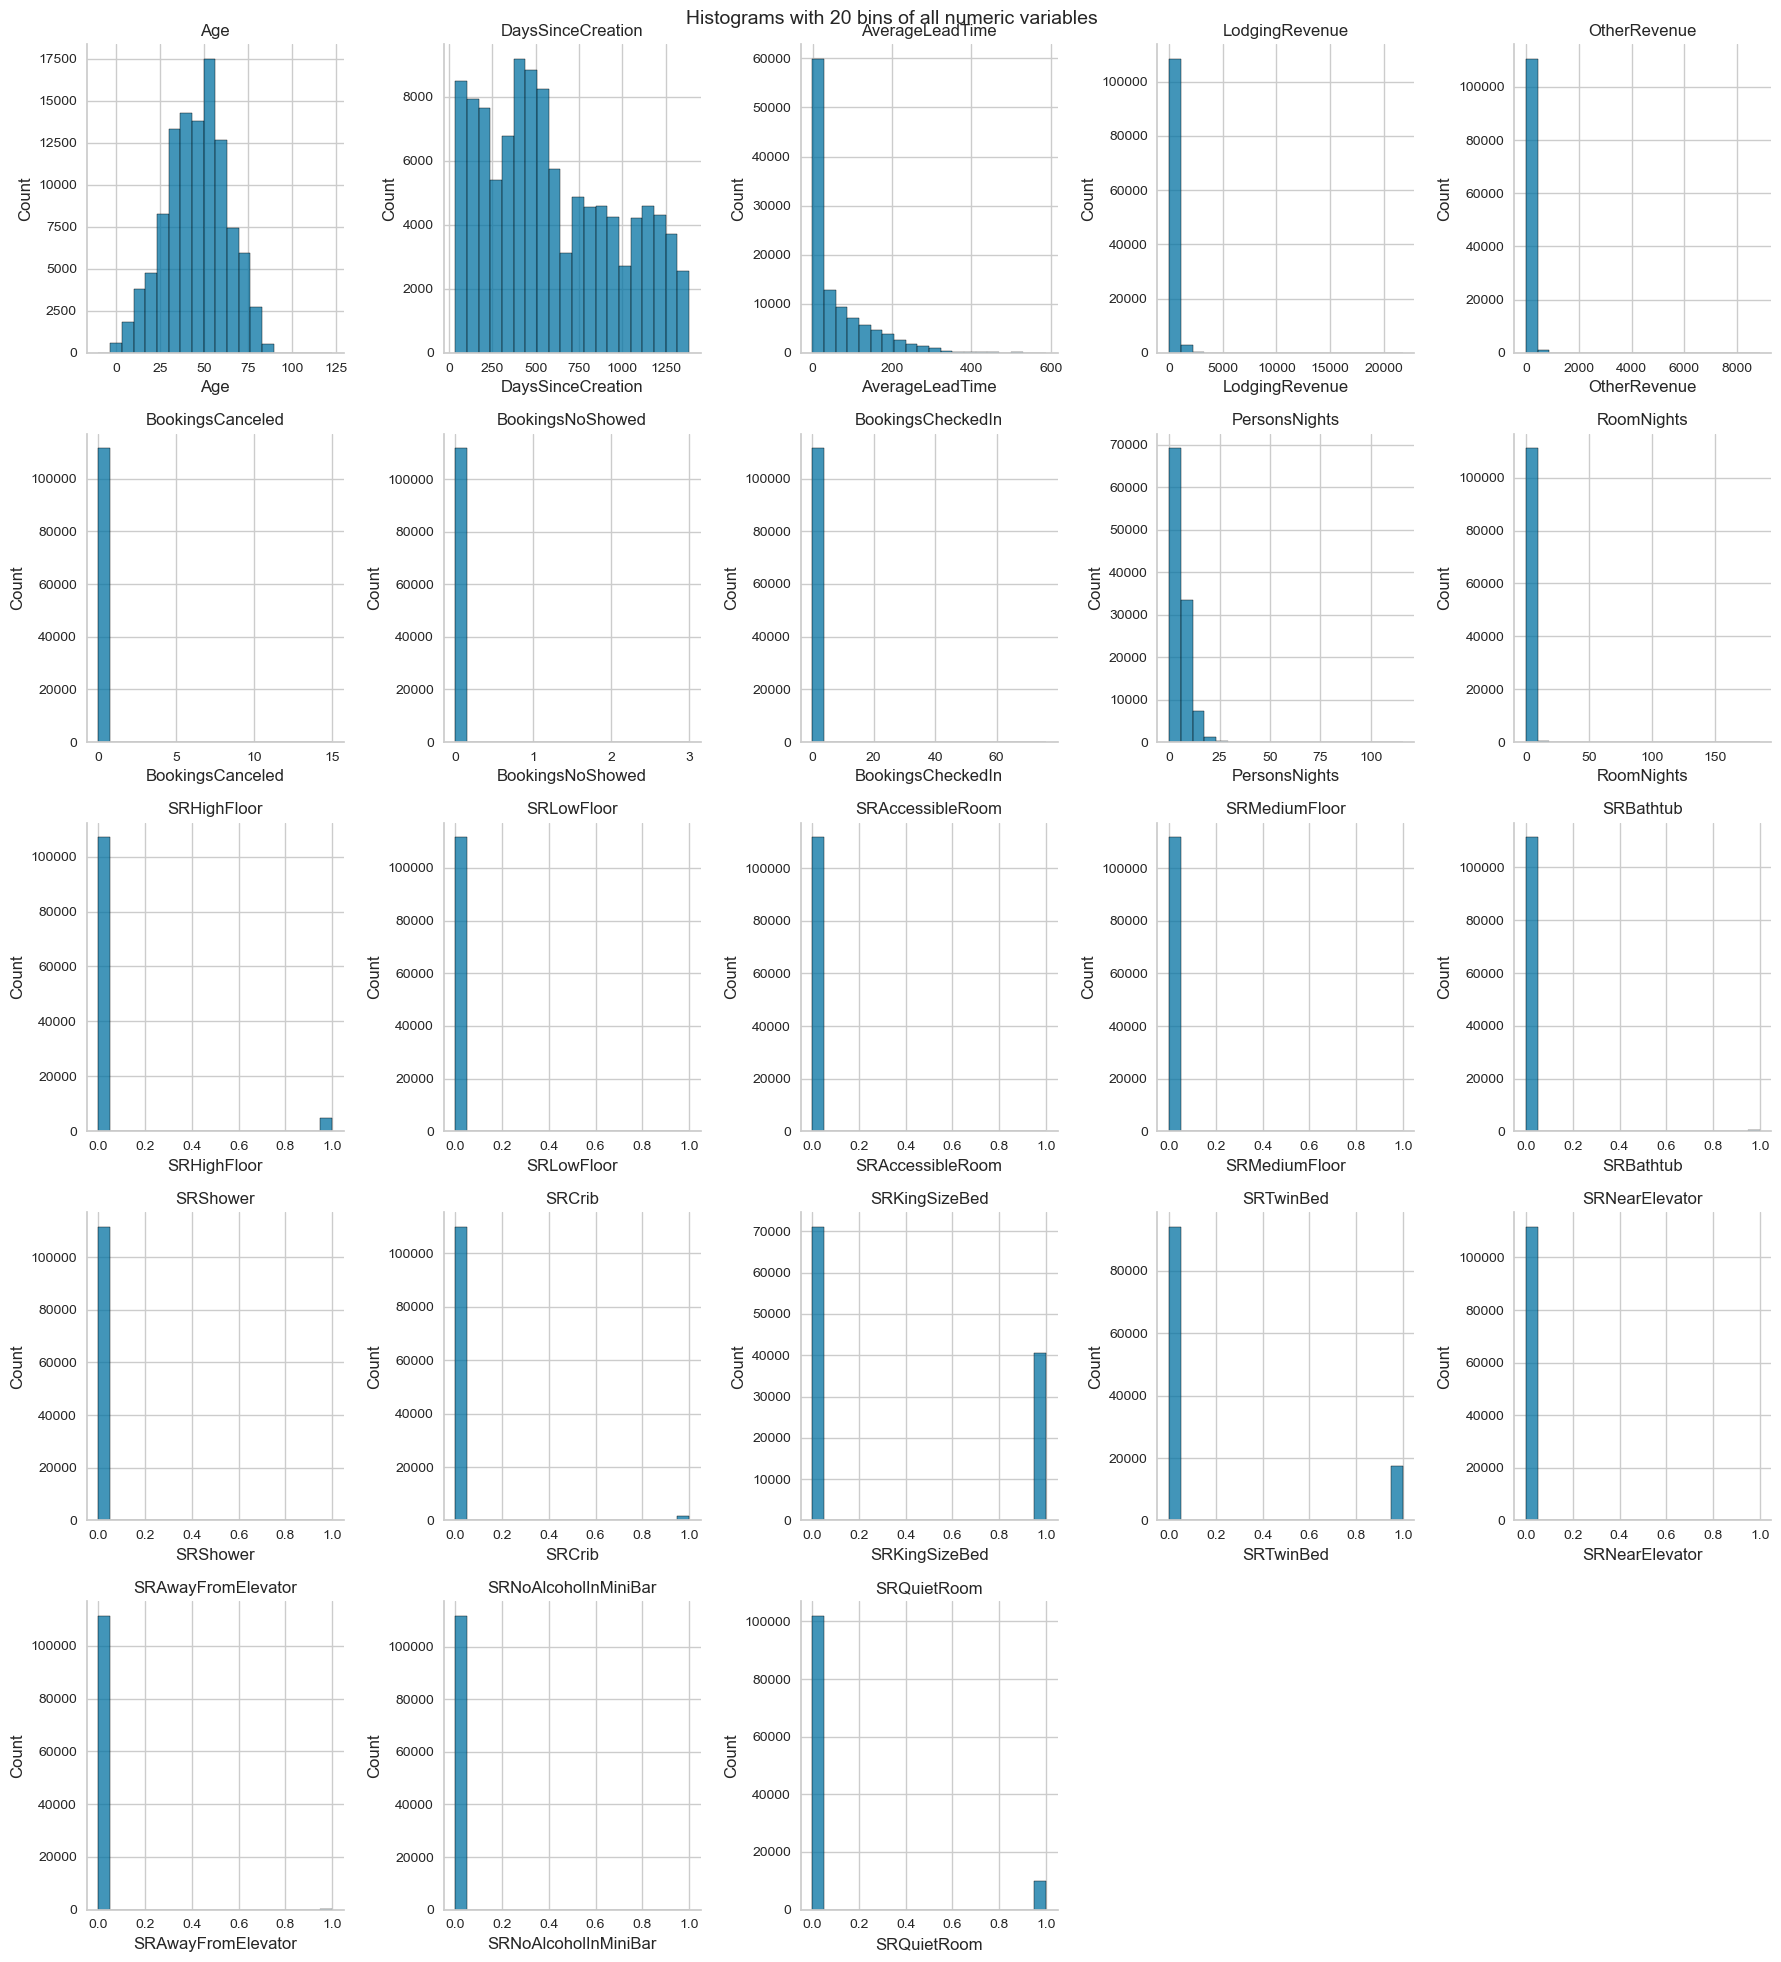

In [729]:
subPlots_label_fontSize = 12
plots_Title_fontSize = 14
numerical_data = data.select_dtypes(include=[np.number]).columns.tolist()
num_vars = len(numerical_data)
num_cols = 5
num_rows = (num_vars // num_cols) + (1 if num_vars % num_cols != 0 else 0)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.histplot(data=data,
                 bins=20,
                 x=var,
                 ax=ax[i],
                 kde=False)
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 8`__ Boxplot of numeric variables

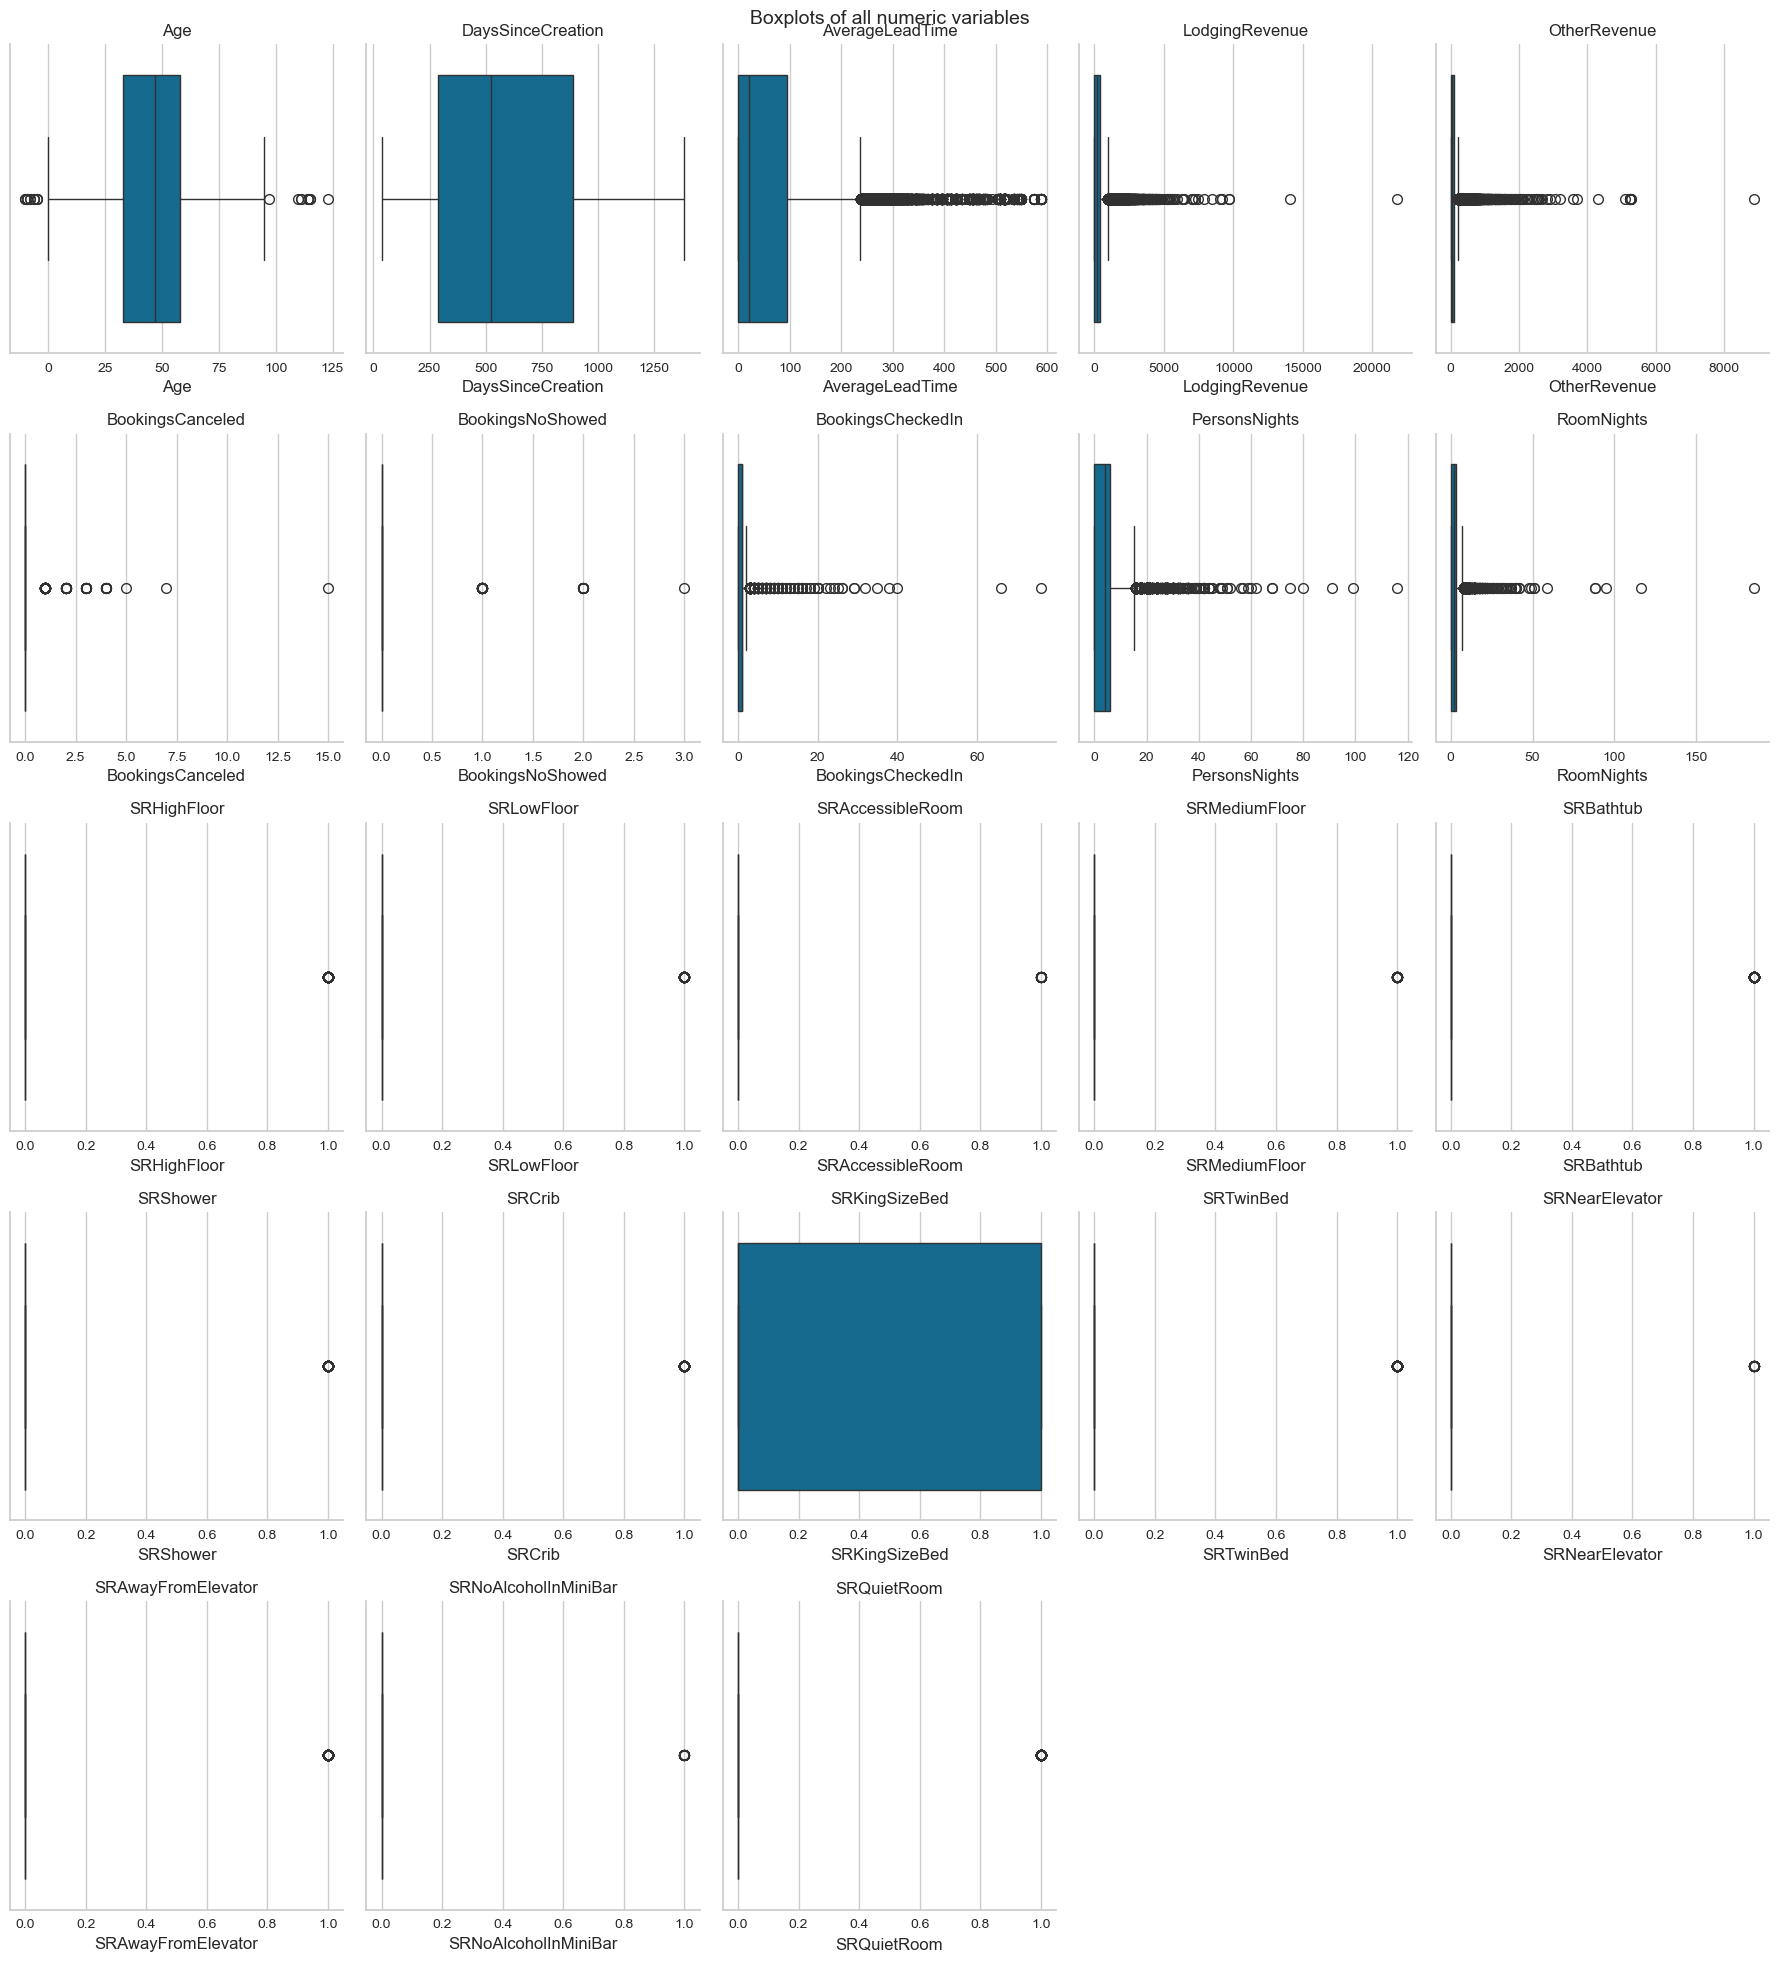

In [730]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))
ax = ax.flatten()

for i, var in enumerate(numerical_data):
    sns.boxplot(data=data, x=var, ax=ax[i])
    ax[i].set_title(var, fontsize=subPlots_label_fontSize)

for j in range(i + 1, len(ax)):
    ax[j].axis('off')

sns.despine()
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize)
plt.tight_layout()
plt.show()

__`Step 9`__ Check if the Customer Preferences have only binary values (0 or 1)

In [731]:
for col in binary_cols:
    unique_values = data[col].unique()
    if not set(unique_values).issubset({0, 1}):
        print(f"Column {col} contains values other than 0 and 1: {unique_values}")

__`Step 10`__ Distribution of the variables with binary values (0 or 1)

In [732]:
for col in binary_cols:
    print(f"Value counts for {col}:")
    print(data[col].value_counts(dropna=False))
    print("-" * 40)

Value counts for SRHighFloor:
SRHighFloor
0    106983
1      4750
Name: count, dtype: int64
----------------------------------------
Value counts for SRLowFloor:
SRLowFloor
0    111587
1       146
Name: count, dtype: int64
----------------------------------------
Value counts for SRMediumFloor:
SRMediumFloor
0    111647
1        86
Name: count, dtype: int64
----------------------------------------
Value counts for SRAccessibleRoom:
SRAccessibleRoom
0    111708
1        25
Name: count, dtype: int64
----------------------------------------
Value counts for SRBathtub:
SRBathtub
0    111383
1       350
Name: count, dtype: int64
----------------------------------------
Value counts for SRShower:
SRShower
0    111551
1       182
Name: count, dtype: int64
----------------------------------------
Value counts for SRCrib:
SRCrib
0    109925
1      1808
Name: count, dtype: int64
----------------------------------------
Value counts for SRKingSizeBed:
SRKingSizeBed
0    71144
1    40589
Name: cou

__`Step 11`__ Distribution of the categorical variables

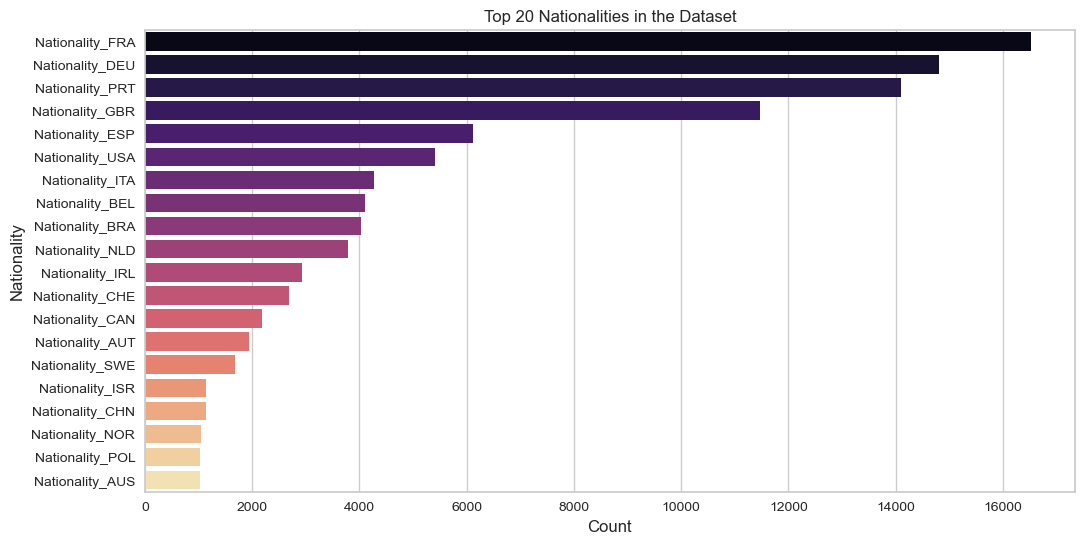

In [733]:
top_n = 20
top_nationalities = nationality_counts.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_nationalities.values, y=top_nationalities.index, palette="magma")
plt.title(f"Top {top_n} Nationalities in the Dataset")
plt.xlabel("Count")
plt.ylabel("Nationality")
plt.show()

In [734]:
data[nationality_cols] = data[nationality_cols].astype(int)

In [735]:
threshold = len(data) * 0.05
nationality_counts = data[nationality_cols].sum()
top_nationalities = nationality_counts[nationality_counts > threshold].index
data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)
data.drop(columns=nationality_cols, inplace=True)

C:\Users\gonca\AppData\Local\Temp\ipykernel_19112\1282853520.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["Nationality_Processed"] = data[top_nationalities].idxmax(axis=1)


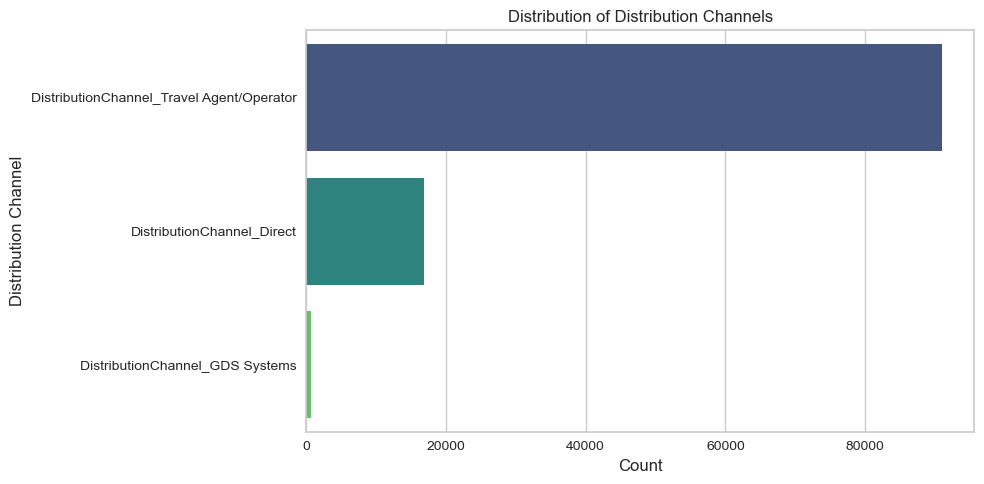

In [736]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x=distribution_counts.values, y=distribution_counts.index, palette="viridis", ax=ax)
ax.set_title("Distribution of Distribution Channels")
ax.set_xlabel("Count")
ax.set_ylabel("Distribution Channel")

plt.tight_layout()
plt.show()

In [737]:
bool_cols = ['DistributionChannel_Direct', 'DistributionChannel_GDS Systems', 'DistributionChannel_Travel Agent/Operator']
data[bool_cols] = data[bool_cols].astype(int)

In [738]:
print(data['BookingsNoShowed'].value_counts())

BookingsNoShowed
0    111676
1        48
2         8
3         1
Name: count, dtype: int64


In [739]:
print(data['BookingsCheckedIn'].value_counts())

BookingsCheckedIn
1     76474
0     33198
2      1634
3       201
4        57
5        33
7        30
6        19
9        13
8        12
10       12
15        7
11        7
16        5
13        5
20        4
12        3
29        2
26        2
18        2
40        1
22        1
24        1
19        1
25        1
14        1
23        1
76        1
66        1
32        1
17        1
38        1
35        1
Name: count, dtype: int64


Since the BookingsNoShowed variable is highly imbalanced, we can simplify it into a binary feature:

- 0 → Never No-Showed
- 1 or more → At Least One No-Show

In [740]:
data["HasNoShow"] = (data["BookingsNoShowed"] > 0).astype(int)

Since almost all customers have 0 canceled bookings, we can simplify it:

- 0 → Never canceled
- 1 or more → At least one cancellation

In [741]:
data["HasCanceled"] = (data["BookingsCanceled"] > 0).astype(int)

Since BookingsCheckedIn is right-skewed, a log transformation can make it more normally distributed:

In [742]:
data["Log_BookingsCheckedIn"] = np.log1p(data["BookingsCheckedIn"])

In [743]:
data.drop(columns=["BookingsNoShowed", "BookingsCanceled", "BookingsCheckedIn"], inplace=True)

# Data Preparation

### Missing Values Handling

In [744]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [745]:
print(data.isnull().sum())

Age                                          0
DaysSinceCreation                            0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
PersonsNights                                0
RoomNights                                   0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed                                    0
SRNearElevator                               0
SRAwayFromElevator                           0
SRNoAlcoholInMiniBar                         0
SRQuietRoom                                  0
DistributionChannel_Direct                   0
DistributionC

Remove Negative Values

In [746]:
numerical_cols = data.select_dtypes(include=['number']).columns
data[numerical_cols] = data[numerical_cols].clip(lower=0)

In [747]:
negative_values = (data[numerical_cols] < 0).sum()
print("Negative values after correction:\n", negative_values)

Negative values after correction:
 Age                                          0
DaysSinceCreation                            0
AverageLeadTime                              0
LodgingRevenue                               0
OtherRevenue                                 0
PersonsNights                                0
RoomNights                                   0
SRHighFloor                                  0
SRLowFloor                                   0
SRAccessibleRoom                             0
SRMediumFloor                                0
SRBathtub                                    0
SRShower                                     0
SRCrib                                       0
SRKingSizeBed                                0
SRTwinBed                                    0
SRNearElevator                               0
SRAwayFromElevator                           0
SRNoAlcoholInMiniBar                         0
SRQuietRoom                                  0
DistributionChannel_Direc

### Outliers Handling

In [748]:
data = data[((data['Age'] >= 0) & (data['Age'] <= 100))]

Outliers in (PersonsNights < RoomNights)

In [749]:
invalid_rows = data[data['PersonsNights'] < data['RoomNights']]
data = data[data['PersonsNights'] >= data['RoomNights']]

print(f"Rows eliminated due to PersonsNights < RoomNights: {invalid_rows.shape[0]}")

Rows eliminated due to PersonsNights < RoomNights: 28


Cap and Log Transformation

In [750]:
zero_count = (data["LodgingRevenue"] == 0).sum()
print(f"Number of zero values in LodgingRevenue: {zero_count}")
zero_percentage = (data["LodgingRevenue"] == 0).mean() * 100
print(f"Percentage of zero values in LodgingRevenue: {zero_percentage:.2f}%")
other_zero_count = (data["OtherRevenue"] == 0).sum()
print(f"Number of zero values in OtherRevenue: {other_zero_count}")

Number of zero values in LodgingRevenue: 33765
Percentage of zero values in LodgingRevenue: 30.23%
Number of zero values in OtherRevenue: 33549


In [751]:
data["HasLodgingRevenue"] = (data["LodgingRevenue"] > 0).astype(int)
data["HasOtherRevenue"] = (data["OtherRevenue"] > 0).astype(int)

In [752]:
data["LodgingRevenue_Log"] = np.log1p(data["LodgingRevenue"])
data["OtherRevenue_Log"] = np.log1p(data["OtherRevenue"])
data["AverageLeadTime_Log"] = np.log1p(data["AverageLeadTime"])
data["PersonsNights_Log"] = np.log1p(data["PersonsNights"])
data["RoomNights_Log"] = np.log1p(data["RoomNights"])

In [753]:
data["LodgingRevenue_Log"].clip(upper=np.log1p(6000), inplace=True)
data["OtherRevenue_Log"].clip(upper=np.log1p(3000), inplace=True)
data["AverageLeadTime_Log"].clip(upper=np.log1p(300), inplace=True)
data["PersonsNights_Log"].clip(upper=np.log1p(35), inplace=True)
data["RoomNights_Log"].clip(upper=np.log1p(30), inplace=True)

In [754]:
data.drop(columns=['LodgingRevenue', 'OtherRevenue', 'AverageLeadTime', 'PersonsNights', 'RoomNights'], inplace=True)

### Outliers Check

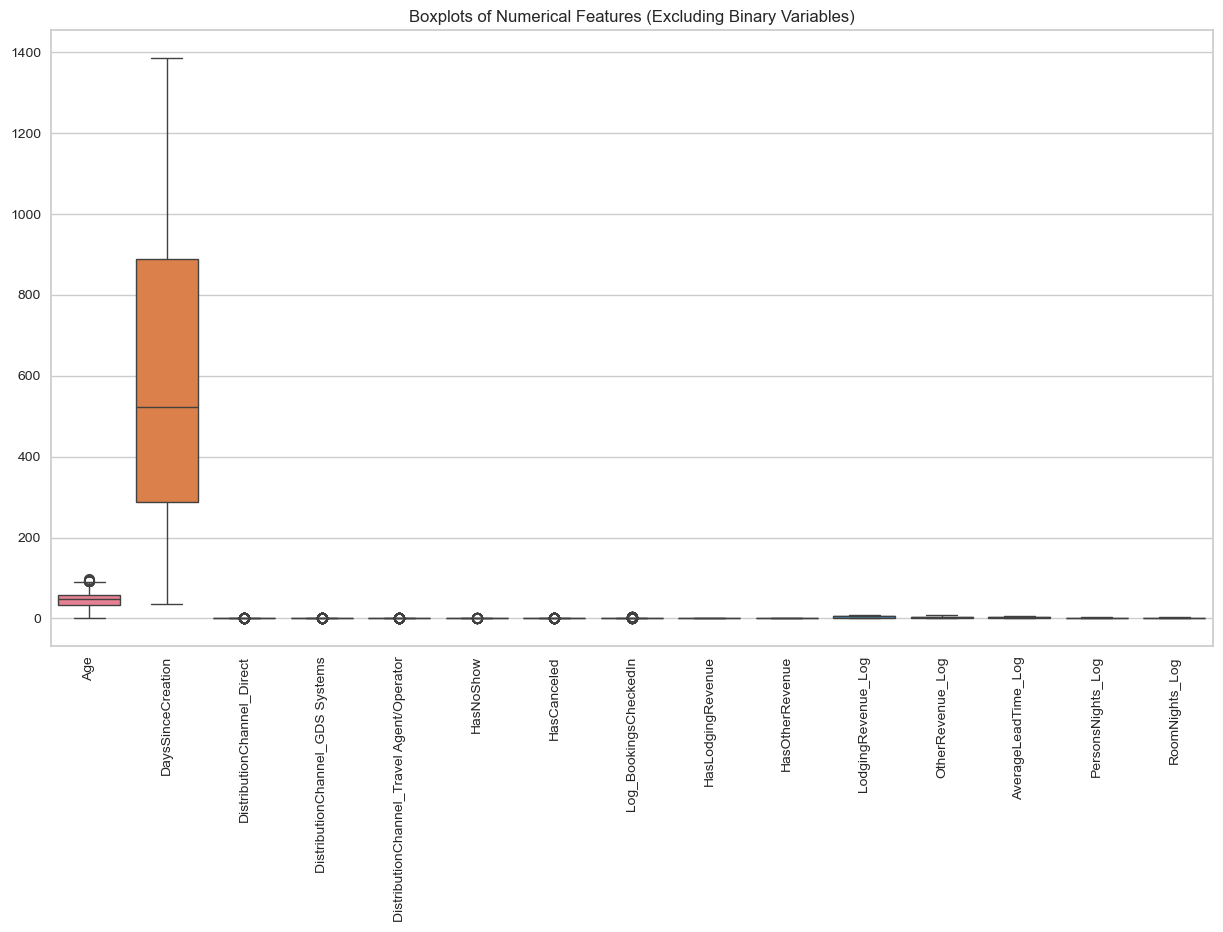

In [755]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]

plt.figure(figsize=(15, 8))
sns.boxplot(data=data[num_cols])
plt.xticks(rotation=90)
plt.title("Boxplots of Numerical Features (Excluding Binary Variables)")
plt.show()

### Correlations

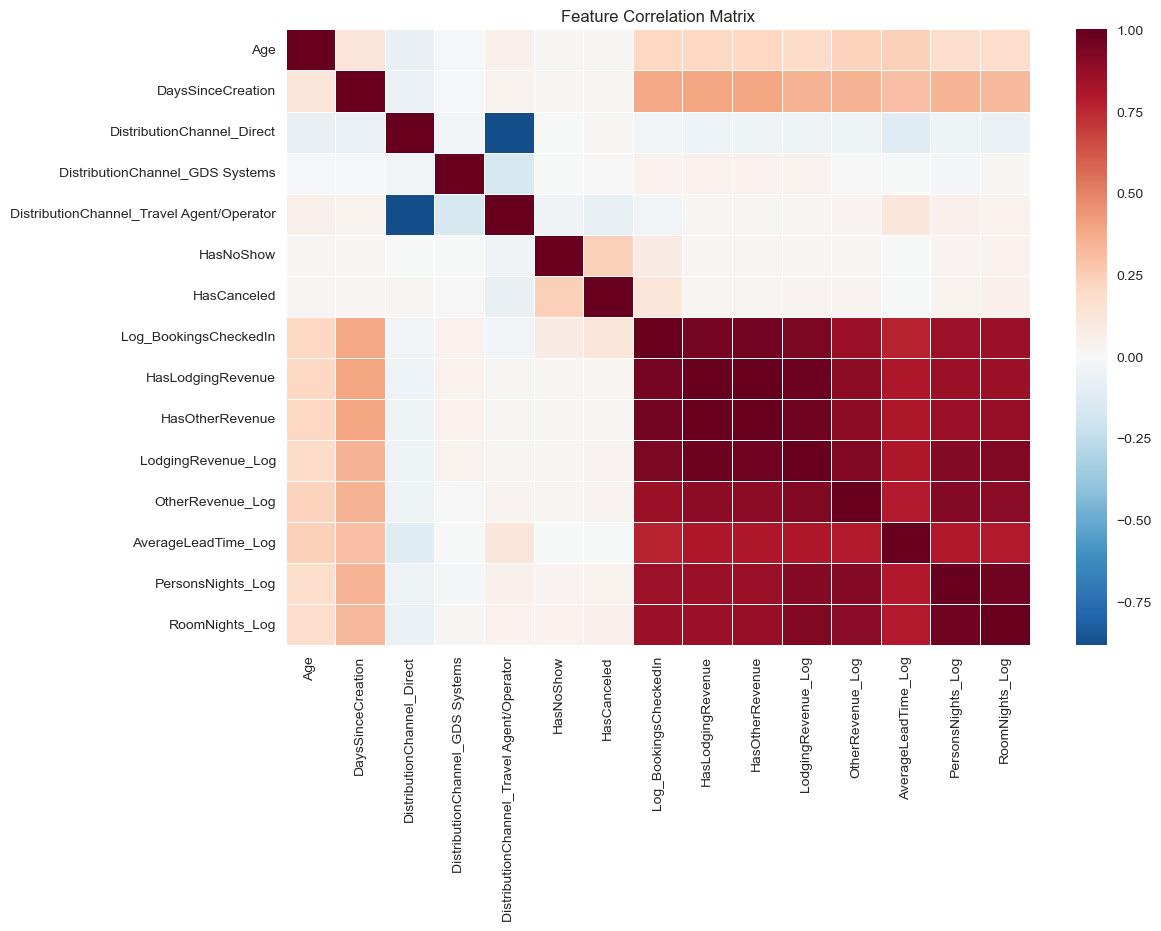

In [756]:
binary_cols = [
    "SRHighFloor", "SRLowFloor", "SRMediumFloor", "SRAccessibleRoom",
    "SRBathtub", "SRShower", "SRCrib", "SRKingSizeBed", "SRTwinBed",
    "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"
]
num_cols = [col for col in data.select_dtypes(include=["number"]).columns if col not in binary_cols]
corr_matrix = data[num_cols].corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    corr_matrix, 
    annot=False,  
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5
)
plt.title("Feature Correlation Matrix")
plt.show()

### Merge Features based on the Correlation

In [757]:
data["TotalNights_Log"] = data["PersonsNights_Log"] + data["RoomNights_Log"]
data.drop(columns=["PersonsNights_Log", "RoomNights_Log"], inplace=True)

In [758]:
data["TotalRevenue_Log"] = data["LodgingRevenue_Log"] + data["OtherRevenue_Log"]
data.drop(columns=["LodgingRevenue_Log", "OtherRevenue_Log"], inplace=True)

In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows
print(data.dtypes)
pd.reset_option('display.max_rows')  # Reset to default after
data.dtypes.value_counts()
non_numeric_cols = data.select_dtypes(exclude=['number']).columns
print("❌ Non-numeric columns found:", list(non_numeric_cols))
print(data["Nationality_Processed"].value_counts())

Age                                          float64
DaysSinceCreation                              int64
SRHighFloor                                    int64
SRLowFloor                                     int64
SRAccessibleRoom                               int64
SRMediumFloor                                  int64
SRBathtub                                      int64
SRShower                                       int64
SRCrib                                         int64
SRKingSizeBed                                  int64
SRTwinBed                                      int64
SRNearElevator                                 int64
SRAwayFromElevator                             int64
SRNoAlcoholInMiniBar                           int64
SRQuietRoom                                    int64
DistributionChannel_Direct                     int32
DistributionChannel_GDS Systems                int32
DistributionChannel_Travel Agent/Operator      int32
Nationality_Processed                         

### Min Max Scaling

In [ ]:
scaler = MinMaxScaler()
min_max_data = scaler.fit_transform(data)
df_min_max_data = pd.DataFrame(min_max_data, columns=data.columns)

### PCA

After testing, 15 was the optimal number of components because it captures 95% of the variance.

In [ ]:
pca = PCA(n_components=15)
data_pca = pca.fit_transform(min_max_data)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', linestyle='-', label='Cumulative Variance')
plt.axhline(y=0.95, color='g', linestyle='-', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance of First 15 PCA Components')
plt.legend()
plt.show()

total_variance = sum(explained_variance)
print(f"Total variance explained by 15 components: {total_variance:.4f}")
if total_variance < 0.90:
    print("Warning: Less than 90% variance is explained! Consider increasing n_components.")

In [ ]:
pca_columns = [f"PC{i+1}" for i in range(15)]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

print(df_pca.head())

### Check if Clusters Exist (PCA)

In [ ]:
pca_3d = PCA(n_components=15)
data_pca_3d = pca_3d.fit_transform(min_max_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=data_pca_3d[:, 0], cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization')
plt.show()

print(f"PCA Reduced Data Shape: {data_pca.shape}")

### UMAP

In [ ]:
n_neighbors = 30
min_dist = 0.1
fig, ax = plt.subplots(figsize=(12, 10))
umap_reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=123)
data_umap = umap_reducer.fit_transform(min_max_data)

ax.scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
ax.set_title(f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})")
ax.set_xlabel("UMAP Component 1")
ax.set_ylabel("UMAP Component 2")
plt.show()

The best combination depends on your goal:

- If you want highly distinct, compact clusters → n_neighbors=30, min_dist=0.1
- If you want a balance between local and global structure → n_neighbors=15, min_dist=0.3
- If you want wider clusters with more variance → n_neighbors=30, min_dist=0.3

So for this case we choose **wider clusters with more variance → n_neighbors=30, min_dist=0.3**.

In [ ]:
umap_reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=123)
data_umap_3d = umap_reducer_3d.fit_transform(min_max_data)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_umap_3d[:, 0], data_umap_3d[:, 1], data_umap_3d[:, 2], c=data_umap_3d[:, 0], cmap='viridis', alpha=0.5)
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
ax.set_title('3D UMAP Visualization')
plt.show()

Clusters are well-separated ✅
- UMAP effectively groups similar customers while keeping different segments apart.

2D UMAP shows distinct clusters
- Some tight, dense groups → likely strong customer segments.
- Some scattered points → possible outliers.

3D UMAP adds depth
- Shows more variation in customer behavior.
- Some clusters are more connected in 3D, meaning relationships may exist between segments.

### Comparing PCA and UMAP

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PCA Scatter Plot
axes[0].scatter(data_pca[:, 0], data_pca[:, 1], s=3, alpha=0.5)
axes[0].set_title("PCA Projection (First 2 Components)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# UMAP Scatter Plot
axes[1].scatter(data_umap[:, 0], data_umap[:, 1], s=3, alpha=0.5)
axes[1].set_title("UMAP Projection (2D)")
axes[1].set_xlabel("UMAP Component 1")
axes[1].set_ylabel("UMAP Component 2")

plt.tight_layout()
plt.show()

## **PCA vs. UMAP: Key Differences**

### **1. Structure and Clustering**
- **PCA shows a linear structure, while UMAP forms distinct clusters.**
- PCA keeps **global structure** but does **not separate clusters clearly**.
- UMAP **creates well-defined clusters**, indicating it captures **local relationships better**.

### **2. Variance vs. Separability**
- **PCA preserves variance, but UMAP enhances separability.**
- PCA’s data points are **spread along principal axes**, meaning it **prioritizes variance**.
- UMAP **clusters similar points together**, making it better for **segmentation tasks**.

### **3. Clustering Performance**
- **UMAP is more useful for clustering.**
- Since UMAP shows **compact, well-separated groups**, clustering algorithms (K-Means, DBSCAN) will likely **perform better on UMAP embeddings** than PCA.

### **4. Interpretability**
- **PCA is better for interpretability.**
- PCA allows us to **understand the contribution of each feature** to principal components.
- UMAP **does not preserve a direct feature-to-component relationship**.

# Clustering

In [ ]:
customer_demographics = ["Age", "Nationality_Processed_DEU", "Nationality_Processed_FRA", "Nationality_Processed_GBR", "Nationality_Processed_Other", "Nationality_Processed_PRT"]
booking_behavior = ["DaysSinceCreation", "AverageLeadTime_Log"]
stay_room_preferences = ["BookingsCheckedIn", "TotalNights_Log", "SRKingSizeBed", "SRTwinBed", "SRQuietRoom"]
revenue_spending = ["TotalRevenue_Log"]
booking_channel = ["DistributionChannel_Corporate", "DistributionChannel_Direct", "DistributionChannel_GDS Systems", "DistributionChannel_Travel Agent/Operator"]

feature_groups = {
    "Customer Demographics": customer_demographics,
    "Booking Behavior": booking_behavior,
    "Stay & Room Preferences": stay_room_preferences,
    "Revenue & Spending": revenue_spending,
    "Booking Channel": booking_channel
}

### K-Means

In [ ]:
kmeans = KMeans(random_state=123, n_init=10)
plt.figure(figsize=(8, 5))
visualizer = KElbowVisualizer(kmeans, k=(2, 15), metric='distortion', timings=False)
visualizer.fit(min_max_data)
visualizer.show()

### K-Means for the Groups

In [ ]:
for group_name, selected_features in feature_groups.items():
    print(f"\n Running K-Means for Feature Group: {group_name}")
    X_selected = df_min_max_data[selected_features]
    kmeans = KMeans(n_clusters=7, random_state=123, n_init=10)
    y_kmeans = kmeans.fit_predict(X_selected)
    print(f"Clustering complete for {group_name}")
    print(f"Unique clusters: {set(y_kmeans)}\n")
    
    if X_selected.shape[1] >= 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(X_selected.iloc[:, 0], X_selected.iloc[:, 1], c=y_kmeans, cmap="viridis", alpha=0.6)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
        plt.xlabel(selected_features[0])
        plt.ylabel(selected_features[1] if len(selected_features) > 1 else "Feature 2")
        plt.title(f"K-Means Clustering for {group_name} (K={K})")
        plt.legend()
        plt.show()

### K-Means with PCA

In [ ]:
n_pca_components = 15
pca = PCA(n_components=n_pca_components)
data_pca = pca.fit_transform(min_max_data)
kmeans_pca = KMeans(n_clusters=7, random_state=123, n_init=10)
y_kmeans_pca = kmeans_pca.fit_predict(data_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=y_kmeans_pca, palette="viridis", alpha=0.6)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering on PCA Reduced Data (K=7)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_pca, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

### K-Means with UMAP

In [ ]:
kmeans_umap = KMeans(n_clusters=7, random_state=123, n_init=10)
y_kmeans_umap = kmeans_umap.fit_predict(data_umap)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_umap[:, 0], y=data_umap[:, 1], hue=y_kmeans_umap, palette="viridis", alpha=0.6)
plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], s=200, c="red", marker="X", label="Centroids")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("K-Means Clustering on UMAP Reduced Data (K=7)")
plt.legend()
plt.grid()
plt.show()

unique, counts = np.unique(y_kmeans_umap, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
print(f"Cluster Distribution: {cluster_distribution}")

In [ ]:
"""
Analisar os Clusters: Estatisticas, visualizar e finalmente descrever
"""